In [1]:
# Trying to justify that we need a method to merge down the multiple annotations

from scipy import stats

# Constants
metrics = {"F3" : 0, "F05" : 1}
K = 6
N = 50
control_idxs = np.asarray([8, 9, 10, 14, 37])

def compute_anova(samples):
    anova_input = tuple(samples.T)
    f_val, p_val = stats.f_oneway(*anova_input)
    print "\tF(%d, %d) = %.3f, p = %.3f" % (samples.shape[1]-1, samples.shape[1]*(samples.shape[0] - 1), f_val, p_val)

In [2]:
data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2b.npz"
data = np.load(open(data_path, "r")) # Ntracks x annotators x annotators x metric

# ANOVAS with all the annotations combined
samples = np.zeros((N, K*(K-1)/2))
idx = np.triu_indices(K, k=1)  # Indeces from the symmetric square matrix of comparison
for metric in metrics.keys():
    for i, track in enumerate(data):
        evaluations = track[:, :, metrics[metric]]
        samples[i, :] = evaluations[idx]
    print "One-way ANOVA for metric %s:" % metric
#     A = (samples - np.mean(samples, axis=0)) / std(samples, axis=0)
#     print np.var(A[:, 0]), np.var(A[:, 1]), A[0,0], A[0,1]
#     samples = samples.T / np.max(samples, axis=1)
#     samples = samples.T
    amax = 0.9
    amin = 0.6
    on = (amax - amin) * np.random.random(50) + amin
    on = np.reshape(on, (50,1))
    samples = np.hstack((samples, on, on, on, on, on, on))
    compute_anova(samples)
    samples = np.zeros((N, K*(K-1)/2))

# ANOVAS of all annotations against each annotation separately
samples = np.zeros((N, K-1))
for ann_id in xrange(K):
    for metric in metrics.keys():
        for i, track in enumerate(data):
            samples[i, :] = np.concatenate((track[0, 1:ann_id+1, metrics[metric]], track[ann_id, ann_id+1:, metrics[metric]]))
        print "One-way ANOVA for metric %s against Ann%d:" % (metric, ann_id)
        compute_anova(samples)

One-way ANOVA for metric F05:
	F(20, 1029) = 32.277, p = 0.000
One-way ANOVA for metric F3:
	F(20, 1029) = 7.966, p = 0.000
One-way ANOVA for metric F05 against Ann0:
	F(4, 245) = 1.205, p = 0.309
One-way ANOVA for metric F3 against Ann0:
	F(4, 245) = 1.047, p = 0.383
One-way ANOVA for metric F05 against Ann1:
	F(4, 245) = 1.711, p = 0.148
One-way ANOVA for metric F3 against Ann1:
	F(4, 245) = 0.938, p = 0.443
One-way ANOVA for metric F05 against Ann2:
	F(4, 245) = 0.506, p = 0.731
One-way ANOVA for metric F3 against Ann2:
	F(4, 245) = 1.297, p = 0.272
One-way ANOVA for metric F05 against Ann3:
	F(4, 245) = 1.432, p = 0.224
One-way ANOVA for metric F3 against Ann3:
	F(4, 245) = 1.109, p = 0.353
One-way ANOVA for metric F05 against Ann4:
	F(4, 245) = 1.273, p = 0.281
One-way ANOVA for metric F3 against Ann4:
	F(4, 245) = 0.995, p = 0.411
One-way ANOVA for metric F05 against Ann5:
	F(4, 245) = 1.205, p = 0.309
One-way ANOVA for metric F3 against Ann5:
	F(4, 245) = 1.047, p = 0.383


In [7]:
# Example from: http://en.wikipedia.org/wiki/F_test#One-way_ANOVA_example
a1 = np.array([6,8,4,5,3,4])
a2 = np.array([8,12,9,11,6,8])
a3 = np.array([13,9,11,8,7,12])
f_val, p_val = stats.f_oneway(a1, a2, a3)
f_val, p_val = stats.f_oneway(a2, a1, a3, np.ones(6)*20)
print f_val, p_val


71.7647058824 6.99746465859e-11


scores (150,)
150 150
Algorithm factor: F(4, 120)
Annotations factor: F(5, 120)


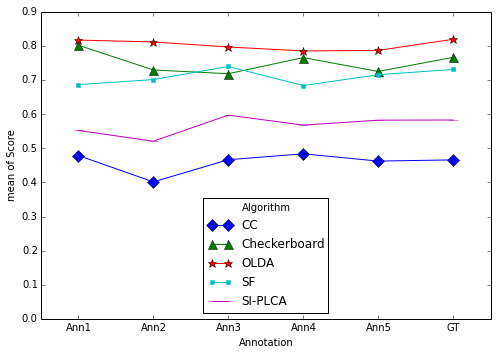

                                        sum_sq  df          F        PR(>F)
C(Algorithm, Sum)                     2.398925   4  26.296787  1.150945e-15
C(Annotation, Sum)                    0.024786   5   0.217363  9.545123e-01
C(Algorithm, Sum):C(Annotation, Sum)  0.061447  20   0.134715  9.999973e-01
Residual                              0.000000   0   0.000000  0.000000e+00

[4 rows x 4 columns]


In [42]:
# Plots for Dissertation: CONTROL ANOVA MULTIPLE ANNOTATIONS

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
    
algo_ids = ["OLDA", "SI-PLCA", "SF", "CC", "Checkerboard"]
annot_ids = ["GT"] + ["Ann%d" % i for i in xrange(1, 6)]
data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2a-nottrimmed.npz"
data = np.load(open(data_path, "r")) # Ntracks x num_annotators x num_algos x num_metrics
algos = []
annots = []
scores = np.empty(0)
n = len(algo_ids)
for i, track in enumerate(data):
    # Remove challenging group
    if i not in control_idxs:
        continue
    scores = np.concatenate((scores, track[:, :, 0].flatten()))
    algos += len(annot_ids)*algo_ids
    annots += n*[annot_ids[0]] + n*[annot_ids[1]] + n*[annot_ids[2]] + n*[annot_ids[3]] + n*[annot_ids[4]] + n*[annot_ids[5]]
print "scores", scores.shape
print len(algos), len(annots)
print "Algorithm factor: F(%d, %d)" % (len(algo_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))
print "Annotations factor: F(%d, %d)" % (len(annot_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))

# To DataFrame
d = { 
     "Algorithm"  : algos,
     "Annotation" : annots,
     "Score"      : scores
    }
df = pd.DataFrame(d)

# PLOT
plt.figure(figsize=(7,5))
interaction_plot(df["Annotation"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'c', 'm'],
                 markers=['D', '^', '*', '.', '_'], ms=9, ax=plt.gca(), legendloc="lower center")
plt.gca().set_ylim([0, 0.9])
plt.tight_layout()
plt.savefig("control-ANOVA-F3.pdf")
plt.show()
sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotation, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

In [1]:
# Plots for Dissertation: CHALLENGING ANOVA MULTIPLE ANNOTATIONS

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
    
algo_ids = ["OLDA", "SI-PLCA", "SF", "CC", "Checkerboard"]
annot_ids = ["GT"] + ["Ann%d" % i for i in xrange(1, 6)]
data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2a.npz"
data = np.load(open(data_path, "r")) # Ntracks x num_annotators x num_algos x num_metrics
algos = []
annots = []
scores = np.empty(0)
n = len(algo_ids)
for i, track in enumerate(data):
    # Remove control group
    if i in control_idxs:
        continue
    scores = np.concatenate((scores, track[:, :, 0].flatten()))
    algos += len(annot_ids)*algo_ids
    annots += n*[annot_ids[0]] + n*[annot_ids[1]] + n*[annot_ids[2]] + n*[annot_ids[3]] + n*[annot_ids[4]] + n*[annot_ids[5]]
print "scores", scores.shape
print len(algos), len(annots)
print "Algorithm factor: F(%d, %d)" % (len(algo_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))
print "Annotations factor: F(%d, %d)" % (len(annot_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))

# To DataFrame
d = { 
     "Algorithm"  : algos,
     "Annotation" : annots,
     "Score"      : scores
    }
df = pd.DataFrame(d)

# PLOT
plt.figure(figsize=(7,5))
interaction_plot(df["Annotation"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'c', 'm'],
                 markers=['D', '^', '*', '.', '_'], ms=9, ax=plt.gca(), legendloc="lower center")
plt.gca().set_ylim([.05, 0.31])
plt.tight_layout()
plt.savefig("challenging-ANOVA-F3.pdf")
plt.show()
sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotation, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

NameError: name 'np' is not defined

F05
scores (150,)
150 150
Algorithm factor: F(4, 120)
Annotations factor: F(5, 120)


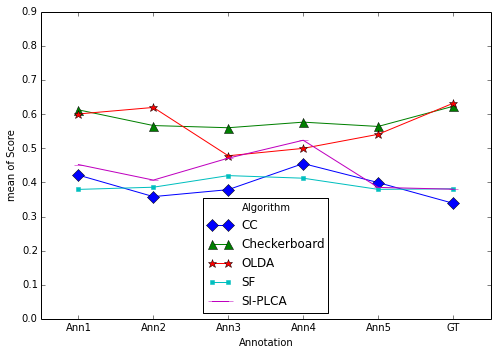

                                        sum_sq  df         F    PR(>F)
C(Algorithm, Sum)                     1.034603   4  7.018513  0.000041
C(Annotation, Sum)                    0.034040   5  0.184736  0.967893
C(Algorithm, Sum):C(Annotation, Sum)  0.221910  20  0.301078  0.998413
Residual                              0.000000   0  0.000000  0.000000

[4 rows x 4 columns]
F3
scores (150,)
150 150
Algorithm factor: F(4, 120)
Annotations factor: F(5, 120)


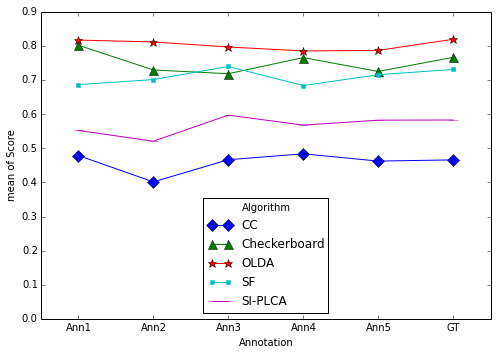

                                        sum_sq  df          F        PR(>F)
C(Algorithm, Sum)                     2.398925   4  26.296787  1.150945e-15
C(Annotation, Sum)                    0.024786   5   0.217363  9.545123e-01
C(Algorithm, Sum):C(Annotation, Sum)  0.061447  20   0.134715  9.999973e-01
Residual                              0.000000   0   0.000000  0.000000e+00

[4 rows x 4 columns]


In [23]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
    
algo_ids = ["OLDA", "SI-PLCA", "SF", "CC", "Checkerboard"]
# algo_ids = ["Algo1", "Algo5"]
annot_ids = ["GT"] + ["Ann%d" % i for i in xrange(1, 6)]
# data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2a.npz"
data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2a-nottrimmed.npz"
data = np.load(open(data_path, "r")) # Ntracks x num_annotators x num_algos x num_metrics
for metric in metrics.keys():
    print metric
    algos = []
    annots = []
    scores = np.empty(0)
    n = len(algo_ids)
    for i, track in enumerate(data):
        # Remove control group
        if i not in control_idxs:
            continue
#         scores = np.concatenate((scores, track[:, [0,4], metrics[metric]].flatten()))
#         scores[i*12:(i*12)+2] = 1
        scores = np.concatenate((scores, track[:, :, metrics[metric]].flatten()))
        algos += len(annot_ids)*algo_ids
        annots += n*[annot_ids[0]] + n*[annot_ids[1]] + n*[annot_ids[2]] + n*[annot_ids[3]] + n*[annot_ids[4]] + n*[annot_ids[5]]
    print "scores", scores.shape
    print len(algos), len(annots)
    print "Algorithm factor: F(%d, %d)" % (len(algo_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))
    print "Annotations factor: F(%d, %d)" % (len(annot_ids) - 1, len(scores) - len(annot_ids) * len(algo_ids))
    
    # To DataFrame
    d = { 
         "Algorithm"  : algos,
         "Annotation" : annots,
         "Score"      : scores
        }
    df = pd.DataFrame(d)
#     print df
    
    plt.figure(figsize=(7,5))
#     interaction_plot(df["Algorithm"], df["Annotation"],
#                      df["Score"], colors=['b', 'g', 'r', 'c', 'm', 'k'],
#                      markers=['D', '^', '*', '.', '_', '*'], ms=10, ax=plt.gca())
    interaction_plot(df["Annotation"], df["Algorithm"],
                     df["Score"], colors=['b', 'g', 'r', 'c', 'm'],
                     markers=['D', '^', '*', '.', '_'], ms=9, ax=plt.gca(), legendloc="lower center")
#     interaction_plot(df["Annotation"], df["Algorithm"],
#                      df["Score"], colors=['b', 'g'],
#                      markers=['D', '^'], ms=10, ax=plt.gca())
    plt.gca().set_ylim([0, 0.9])
    plt.tight_layout()
    plt.savefig("control-ANOVA-%s.pdf" % metric)
    plt.show()
    sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotation, Sum)", data=df).fit()
    print anova_lm(sum_lm, typ=2)

    

In [185]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
    
data_path = "/Users/uri/Dropbox/NYU/Publications/ISMIR2014-NietoHumphreyFarboodBello/exp2a.npz"
algo_ids = ["Algo1", "Algo5"]
annotations = {"GT": 0, "Ann1": 1, "Ann2": 2, "Ann3": 3, "Ann4": 4, "Ann5": 5}
annot = "GT"
data = np.load(open(data_path, "r"))  # Ntracks x num_annotators x num_algos x num_metrics
for metric in metrics.keys():
    algos = []
    annots = []
    scores = np.empty(0)
    n = len(algo_ids)
    for i, track in enumerate(data):
        # Remove control group
        if i in control_idxs:
            continue
        scores = np.concatenate((scores, track[annotations[annot], [0,2], metrics[metric]].flatten()))
        algos += algo_ids

#     print len(algos), len(scores), np.mean(scores[::2]), np.mean(scores[1::2])
    
    t_val, p_val = stats.ttest_ind(scores[::2], scores[1::2])
    print "t-test for metric %s:\n\tt-value: %.3f, p-value: %.4f" % (metric, t_val, p_val)
    
    # To DataFrame
    d = { 
         "Algorithm"  : algos,
         "Score"      : scores
        }
    df = pd.DataFrame(d)
    
    sum_lm = ols("Score ~ C(Algorithm, Sum)", data=df).fit()
    print "One-way ANOVA for metric %s:\n%s" % (metric, anova_lm(sum_lm, typ=2))


t-test for metric F05:
	t-value: 1.042, p-value: 0.3004
One-way ANOVA for metric F05:
                     sum_sq  df         F    PR(>F)
C(Algorithm, Sum)  0.004719   1  1.084983  0.300439
Residual           0.000000   0  0.000000  0.000000

[2 rows x 4 columns]
t-test for metric F3:
	t-value: -3.619, p-value: 0.0005
One-way ANOVA for metric F3:
                     sum_sq  df          F    PR(>F)
C(Algorithm, Sum)  0.258257   1  13.093637  0.000494
Residual           0.000000   0   0.000000  0.000000

[2 rows x 4 columns]


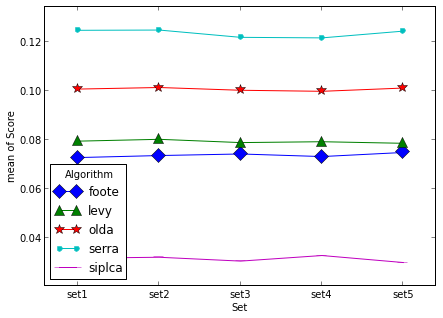

                                 sum_sq  df           F        PR(>F)
C(Set, Sum)                    0.000225   4    0.021706  9.990829e-01
C(Algorithm, Sum)              1.057161   4  102.127194  5.502834e-74
C(Set, Sum):C(Algorithm, Sum)  0.000749  16    0.018099  1.000000e+00
Residual                       0.000000   0    0.000000  0.000000e+00

[4 rows x 4 columns]


In [45]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
    
type_score_dict = {"f2f" : 2, "f2h" : 5, "h2f" : 8, "h2h" : 11}
algo_ids = ["olda", "siplca", "serra", "levy", "foote"]
sets_ids = ["set%d" % i for i in np.arange(1,6)]
data = np.load(open("results_merged.npy", "r"))  # 5 Algos, 50 tracks, 3 merged1 + 3 merged2 + 3 merged3 + 3 merged4 = 12, 5 sets
# type_score = "f2f" 
# type_score = "f2h" 
# type_score = "h2f" 
type_score = "h2h" 

algos = []
sets = []
scores = np.empty(0)
n = len(algo_ids)
for i, algo in enumerate(data):
    for j, track in enumerate(algo):
        # Remove control group
        if j in control_idxs:
            continue
        scores = np.concatenate((scores, track[type_score_dict[type_score], :].flatten()))
        algos += len(sets_ids) * [algo_ids[i]]
        sets += sets_ids
#         print algos, algo_ids[i]
#         print sets
#         print scores
#     print len(algos), len(sets), len(scores)
#     print algos, sets, scores
#     break

# To DataFrame
d = { 
     "Algorithm" : algos,
     "Set"       : sets,
     "Score"     : scores
    }
df = pd.DataFrame(d)

plt.figure(figsize=(7,5))
interaction_plot(df["Set"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'c', 'm'],
                 markers=['D', '^', '*', '.', '_'], ms=10, ax=plt.gca())
plt.show()
sum_lm = ols("Score ~ C(Set, Sum) * C(Algorithm, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)


(5, 50, 12, 10)
Type:  f2f
Algorithm factor: F(4, 2200)
Set factor: F(9, 2200)
                                 sum_sq  df           F        PR(>F)
C(Algorithm, Sum)              8.201862   4  112.487498  2.383093e-87
C(Set, Sum)                    0.037695   9    0.229770  9.903073e-01
C(Algorithm, Sum):C(Set, Sum)  0.194922  36    0.297037  9.999860e-01
Residual                       0.000000   0    0.000000  0.000000e+00

[4 rows x 4 columns]
Type:  f2h
Algorithm factor: F(4, 2200)
Set factor: F(9, 2200)
                                 sum_sq  df           F         PR(>F)
C(Algorithm, Sum)              2.528568   4  153.143974  1.075302e-115
C(Set, Sum)                    0.015740   9    0.423699   9.230970e-01
C(Algorithm, Sum):C(Set, Sum)  0.039897  36    0.268490   9.999963e-01
Residual                       0.000000   0    0.000000   0.000000e+00

[4 rows x 4 columns]
Type:  h2f
Algorithm factor: F(4, 2200)
Set factor: F(9, 2200)
                                  sum_sq  df  

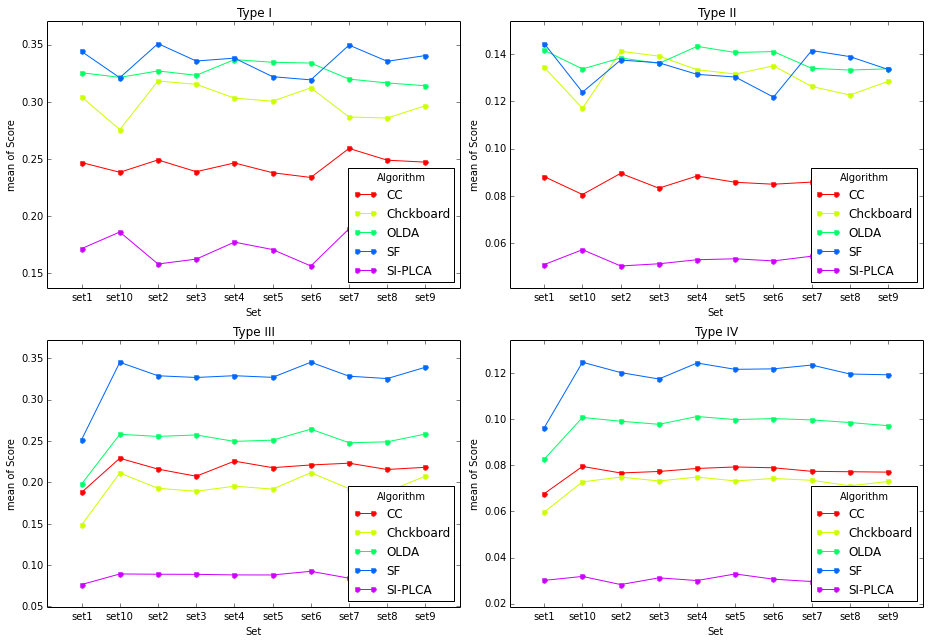

In [60]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from collections import OrderedDict

type_score_dict = OrderedDict()
type_score_dict["f2f"] = 2 
type_score_dict["f2h"] = 5 
type_score_dict["h2f"] = 8
type_score_dict["h2h"] = 11

titles = {"f2f" : "Type I", "f2h" : "Type II", "h2f" : "Type III", "h2h" : "Type IV"}

algo_ids = ["OLDA", "SI-PLCA", "SF", "CC", "Chckboard"]
sets_ids = ["set%d" % i for i in np.arange(1,11)]
data = np.load(open("results_merged-triples.npy", "r"))  # 5 Algos, 50 tracks, 3 merged1 + 3 merged2 + 3 merged3 + 3 merged4 = 12, 10 sets
# data = np.load(open("results_merged-pairs.npy", "r")) # 5 Algos, 50 tracks, 3 merged1 + 3 merged2 + 3 merged3 + 3 merged4 = 12, 10 sets

print data.shape

plt.figure(figsize=(13,9))
for k, key in enumerate(type_score_dict.keys()):
    print "Type: ", key
    algos = []
    sets = []
    scores = np.empty(0)
    n = len(algo_ids)
    for i, algo in enumerate(data):
        for j, track in enumerate(algo):
            # Remove control group
            if j in control_idxs:
                continue
            scores = np.concatenate((scores, track[type_score_dict[key], :].flatten()))
            algos += len(sets_ids) * [algo_ids[i]]
            sets += sets_ids
    #     print len(algos), len(sets), len(scores)
    #     print algos, sets, scores
    #     break
    
    print "Algorithm factor: F(%d, %d)" % (len(algo_ids) - 1, len(scores) - len(sets_ids) * len(algo_ids))
    print "Set factor: F(%d, %d)" % (len(sets_ids) - 1, len(scores) - len(sets_ids) * len(algo_ids))
        
    # To DataFrame
    d = { 
         "Algorithm" : algos,
         "Set"       : sets,
         "Score"     : scores
        }
    df = pd.DataFrame(d)
    
    plt.subplot(2,2,k+1)
    interaction_plot(df["Set"], df["Algorithm"],
                     df["Score"], ms=10, ax=plt.gca(), legendloc="lower right")
    plt.title(titles[key])
    sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Set, Sum)", data=df).fit()
    print anova_lm(sum_lm, typ=2)
plt.tight_layout()
plt.savefig("anovas-triplets-robustness.pdf")
# plt.savefig("anovas-pairs-robustness.pdf")
plt.show()